In [ ]:
# Importing Required Libraries
import pandas as pd
import numpy as np
from statistics import variance as v
import matplotlib.pyplot as plt

In [ ]:
# Loading Dataset
df1= pd.read_csv("Complete_old.csv")
df1.drop_duplicates(subset=['Address'])
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4681 entries, 0 to 4680
Data columns (total 50 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Index                                                  4681 non-null   int64  
 1   Address                                                4681 non-null   object 
 2   FLAG                                                   4681 non-null   int64  
 3   Avg_min_between_sent_tnx                               4681 non-null   float64
 4   Avg_min_between_received_tnx                           4681 non-null   float64
 5   Time_Diff_between_first_and_last_(Mins)                4681 non-null   float64
 6   Sent_tnx                                               4681 non-null   int64  
 7   Received_Tnx                                           4681 non-null   int64  
 8   Number_of_Created_Contracts                     

In [ ]:
df1.isnull().sum()

Index                                                      0
Address                                                    0
FLAG                                                       0
Avg_min_between_sent_tnx                                   0
Avg_min_between_received_tnx                               0
Time_Diff_between_first_and_last_(Mins)                    0
Sent_tnx                                                   0
Received_Tnx                                               0
Number_of_Created_Contracts                                0
Unique_Received_From_Addresses                             0
Unique_Sent_To_Addresses                                   0
min_value_received                                         0
max_value_received                                         0
avg_val_received                                           0
min_val_sent                                               0
max_val_sent                                               0
avg_val_sent            

In [ ]:
df1.duplicated().sum()

0

In [ ]:
same_ether=df1[df1['total_ether_received']==df1['total_Ether_sent']]['Address'].index
df1.iloc[same_ether,[21,22]].mean()

total_Ether_sent        0.0
total_ether_received    0.0
dtype: float64

In [ ]:
def data_preprocessing(df):

    #drop unwanted columns
    drop_col=['ERC20_most_sent_token_type','ERC20_most_rec_token_type']
    df2=df.drop(labels=drop_col,axis=1)

    # Replacing null values with mean and mode values
    for i in df2.columns:
      if df2[i].isnull().sum()!=0:
        if df2[i].dtype=='float64':
          mean_value=df2[i].mean()
          df2[i].fillna(mean_value,inplace=True)
        elif df2[i].dtype=='int64':
          mean_value=df2[i].mean()
          df2[i].fillna(mean_value,inplace=True)
        elif df2[i].dtype=='object':
          mode_value=df2[i].mode()[0]
          df2[i].fillna(mode_value,inplace=True)

    # Calculation of variance for each column and removing column with zero variance.
    zero_v=[]
    k=1
    for i in df2.columns:
      if (df2[i].dtype=='int64') or (df2[i].dtype=='float64'):
        v_value=v(df2[i])
        if v_value==0:
          zero_v.append(i)
          #print('Variance:', i, '\t\t',v_value)
          k=k+1

    # Drop columns with zero Variance
    df2.drop(labels=zero_v,axis=1,inplace=True)
    df2.shape

    # Caluclating correlation values and removing columns with low correlation values (0.005)
    less_cor=[]
    #print('Column Name','\t\t','Correlation Value')
    for i in df2.columns:
      if (df2[i].dtype=='int64') or (df2[i].dtype=='float64'):
        correlation=df2['FLAG'].corr(df2[i])
        if abs(correlation)<0.005:
          less_cor.append(i)
          #print(i,'\t\t',correlation)

    #Drop loess correleated columns
    df2.drop(labels=less_cor,axis=1,inplace=True)

    return df2

In [ ]:
df_p=data_preprocessing(df1)
#df_p.to_csv('Cleaned_Complete.csv')
df_p.drop(labels=['Index','Address'],axis=1,inplace=True)

In [ ]:
df_illicit=df_p[df_p['FLAG']==1]
df_licit=df_p[df_p['FLAG']==0]

In [ ]:
# Finding Common transactions between Ether received(FLAG=1) and Ether sent (FLAG=0)
a=df_licit['total_Ether_sent']
b=df_illicit['total_ether_received']
a_set = set(a)
b_set = set(b)

 # Defining set and finding common elements in sets.
if (a_set & b_set):
    common_set=(a_set & b_set)
    print(common_set)
else:
    print("No common elements")

#Initialzing dictionaries to save the index of the common elements from both received and sent.
received_loc={}   # Information for ether received
sent_loc={}       # Information for ether sent
matching_values={}  # Information of values of match

# Iterate through common elements and and find index from two grouped dataframes.
for j,val in enumerate(common_set):
    if (val!=0):
        loc=a[a==val].index
        sent_loc[j]=loc
        #print(loc_j)
        i_loc=b[b==val].index
        received_loc[j]=i_loc
        #print(iloc_j)
        matching_values[j] = val

# Creating dataframe for the sent and received addresses with the values.
sent_add_list = []
received_add_list = []
matching_values_list=[]
matching_values_list_rec=[]

for location, sent_indices in sent_loc.items():
    sent_add = df1.loc[sent_indices, 'Address'].tolist()  # Extracting addresses based on indices for sent addresses
    sent_add_list.extend(sent_add)

    matching_value_1 = matching_values[location]
    matching_values_list.extend([matching_value_1] * len(sent_indices))

for location, received_indices in received_loc.items():
    received_add = df1.loc[received_indices, 'Address'].tolist()  # Extracting addresses based on indices for received addresses
    received_add_list.extend(received_add)

    matching_value_2 = matching_values[location]
    matching_values_list_rec.extend([matching_value_2] * len(received_indices))

print("Length of matching_values:", len(matching_values_list))
print("Length of sent_add_list:", len(sent_add_list))
print("Length of matching_values:", len(matching_values_list_rec))
print("Length of received_add_list:", len(received_add_list))

# Dataframe for sent address
data_1 = pd.DataFrame({
    'Type':'Sent_to_address',
    'Value': matching_values_list,
    'Address': sent_add_list
})
# Dataframe for received address
data_2 = pd.DataFrame({
    'Type':'Received_to_address',
    'Value': matching_values_list_rec,
    'Address': received_add_list
})
result_data=pd.concat([data_1, data_2], ignore_index=True)
#result_data.to_csv('Common_Amounts.csv')



{0.0, 0.5, 2.0, 0.09, 3.0, 1.01, 6.0, 1.0, 15.0}
Length of matching_values: 10
Length of sent_add_list: 10
Length of matching_values: 83
Length of received_add_list: 83


In [ ]:
result_data

,Type,Value,Address
0,Sent_to_address,0.50,0x22f4bda32b59e6207a22660ad23c1f0fdacee992
1,Sent_to_address,0.50,0x2bafe61f1a133f48d1396a8d97aa6eca300f38ec
2,Sent_to_address,2.00,0xe4c7557af9566f4b48a979ac80e0be0fd8198a53
3,Sent_to_address,0.09,0x4877afc42edbf52bf73e475379280ed79fcb8c0c
4,Sent_to_address,3.00,0x4aebc22c346684ce5fe729d334367d56a53352cd
...,...,...,...
88,Received_to_address,1.00,0xd22066c4e511698b626aea89cf70fba5fd3f37d4
89,Received_to_address,1.00,0xf276c0ad29363689792702986667d562a3cb7c04
90,Received_to_address,1.00,0xf33142f5bb228516f93e4267fb5a7241dc241614
91,Received_to_address,15.00,0x68a91eba9c82b475091077e16357bb2dded479f4


# Actual data with groups

In [ ]:
import pandas as pd
phis= pd.read_csv("phishing_scams_gen.csv")
non_phis=pd.read_csv("non_phishing_gen.csv")
all=pd.read_csv("anamika_engineered.csv")
final_df=pd.read_csv('final_dataset_all_addresses_gen.csv')

In [ ]:
phis['Scam_Types']='PHISHING'
phis.head()

,Unnamed: 0,Address,Sent_tnx,Recieved_tnx,Total_Ether_Balance,Max_Value_Received,Min_Value_Received,Total_Ether_Received,Time_Diff_between_first_and_last_(Mins),Total_Transactions(Including_Tnx_to_Create_Contract),...,Total_ERC20_Tnxs,ERC20_Avg_Time_Between_Sent_Tnx,ERC20_Avg_Time_Between_Rec_Tnx,Unique_Received_From_Addresses,Unique_Sent_To_Addresses,ERC20_Uniq_Sent_Addr,ERC20_Uniq_Rec_Addr,Pages,Scam_Types,Files
0,3144,0xc57f1148855e67763a694f7f2c0e68230adc686e,47,21,0.000000,25.277638,0.052667,60.379570,8807.150000,68,...,104,291.864141,11771.260145,20,37,2,28,NaN,PHISHING,NaN
1,6532,0xba83e9ce38b10522e3d6061a12779b7526839eda,129,106,0.001791,160.000000,0.000000,1990.757132,158469.383333,235,...,304,1331.473669,4507.320856,66,50,17,74,NaN,PHISHING,NaN
2,9585,0xaca33c43bd8deac8e1d144baa51fe9c7dd7b010f,42,2,0.059455,739.000000,1.700000,740.700000,9933.583333,44,...,87,14701.040278,2274.108503,1,39,3,3,NaN,PHISHING,NaN
3,9254,0xe858c157deb9912ef7eed94424be3e058bdca529,6,4,0.000000,12.094785,0.046986,22.514634,198634.516667,10,...,13,0.316667,21309.970000,4,6,1,10,NaN,PHISHING,NaN
4,2244,0x6f931bac260e7fcbaa0244d3b43a2bd9e9acf698,357,9,0.000000,540.000000,0.100000,1781.200000,7205.666667,366,...,32,259.638333,50578.580000,5,4,1,3,NaN,PHISHING,NaN


In [ ]:
non_phis.head()

,Unnamed: 0,Address,Sent_tnx,Recieved_tnx,Total_Ether_Balance,Max_Value_Received,Min_Value_Received,Total_Ether_Received,Time_Diff_between_first_and_last_(Mins),Total_Transactions(Including_Tnx_to_Create_Contract),...,Total_ERC20_Tnxs,ERC20_Avg_Time_Between_Sent_Tnx,ERC20_Avg_Time_Between_Rec_Tnx,Unique_Received_From_Addresses,Unique_Sent_To_Addresses,ERC20_Uniq_Sent_Addr,ERC20_Uniq_Rec_Addr,Pages,Scam_Types,Files
0,0,0xf803d6b8023575d1223d035a214b8edaaa0b87c8,0,0,0.000000,0.00,0.00,0.000000,0.00,0,...,0,0.0,0.000000e+00,0,0,0,0,1,IMPERSONATION,IMPERSONATION_Addresses - 1 - 168.csv
1,0,0x722c257c46f9a9df8512f6852553439c608f7d19,0,0,0.000000,0.00,0.00,0.000000,0.00,0,...,0,0.0,0.000000e+00,0,0,0,0,1,IMPERSONATION,IMPERSONATION_Addresses - 1 - 168.csv
2,0,0x2118081829ecc4e2471e3135112731edf97049ec,0,0,0.000000,0.00,0.00,0.000000,0.00,0,...,0,0.0,0.000000e+00,0,0,0,0,1,IMPERSONATION,IMPERSONATION_Addresses - 1 - 168.csv
3,0,0x1a73663e3e343179ee7544734c57ee99b36ae5db,8,6,0.001057,1.00,0.05,4.455547,246.80,14,...,3,0.0,0.000000e+00,6,3,3,0,1,IMPERSONATION,IMPERSONATION_Addresses - 1 - 168.csv
4,0,0x02882f5bd64af55c3737c480dfe79b0115522f46,79,134,0.000000,0.25,0.00,3.005647,1325096.75,213,...,1,0.0,2.706092e+07,109,20,0,1,1,IMPERSONATION,IMPERSONATION_Addresses - 1 - 168.csv


In [ ]:
all.rename(columns = {'Scam_Type':'Scam_Types'}, inplace = True)
all.drop(labels='Unnamed: 0',axis=1,inplace=True)
phis.drop(labels=['Unnamed: 0','Pages','Files'],axis=1,inplace=True)
non_phis.drop(labels=['Unnamed: 0','Pages','Files'],axis=1,inplace=True)

In [ ]:
# all['ether_rec_per_tnx']=all['Total_Ether_Received']/all['Total_Transactions(Including_Tnx_to_Create_Contract)']
# all['ether_sent_per_tnx']=all['Total_Ether_Sent']/all['Total_Transactions(Including_Tnx_to_Create_Contract)']
# all['ether_rec_rate']=all['Total_Ether_Received']/all['Time_Diff_between_first_and_last_(Mins)']
# all['ether_sent_rate']=all['Total_Ether_Received']/all['Time_Diff_between_first_and_last_(Mins)']
# all['av_rec_rate']=all['Avg_Value_Received']/all['Time_Diff_between_first_and_last_(Mins)']
# all['av_sent_rate']=all['Avg_Value_Sent']/all['Time_Diff_between_first_and_last_(Mins)']

In [ ]:
all[all.isnull().any(axis=1)]

,Address,Sent_tnx,Recieved_tnx,Total_Ether_Balance,Max_Value_Received,Min_Value_Received,Total_Ether_Received,Time_Diff_between_first_and_last_(Mins),Total_Transactions(Including_Tnx_to_Create_Contract),Avg_Value_Received,...,ERC20_Min_Val_Sent,ERC20_Max_Val_Sent,Total_ERC20_Tnxs,ERC20_Avg_Time_Between_Sent_Tnx,ERC20_Avg_Time_Between_Rec_Tnx,Unique_Received_From_Addresses,Unique_Sent_To_Addresses,ERC20_Uniq_Sent_Addr,ERC20_Uniq_Rec_Addr,Scam_Types


In [ ]:
combined_data=pd.concat([phis,non_phis,all])
combined_data.head()
combined_data.shape

(12538, 32)

In [ ]:
combined_data.drop_duplicates(subset='Address',inplace=True)
combined_data.shape
index_FFO = combined_data[ (combined_data['Scam_Types'] == 'FAKE_PROJECT') & (combined_data['Scam_Types'] == 'FAKE_RETURNS') & (combined_data['Scam_Types'] == 'OTHER_HACK') ].index
combined_data.drop(index_FFO , inplace=True)
combined_data.head()

,Address,Sent_tnx,Recieved_tnx,Total_Ether_Balance,Max_Value_Received,Min_Value_Received,Total_Ether_Received,Time_Diff_between_first_and_last_(Mins),Total_Transactions(Including_Tnx_to_Create_Contract),Avg_Value_Received,...,ERC20_Uniq_Rec_Addr,Scam_Types,ERC20_Total_Ether_Received,ERC20_Total_Ether_Sent,ERC20_Avg_Val_Rec,ERC20_Avg_Val_Sent,ERC20_Min_Val_Rec,ERC20_Max_Val_Rec,ERC20_Min_Val_Sent,ERC20_Max_Val_Sent
0,0xc57f1148855e67763a694f7f2c0e68230adc686e,47,21,0.000000,25.277638,0.052667,60.379570,8807.150000,68,2.875218,...,28,PHISHING,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0xba83e9ce38b10522e3d6061a12779b7526839eda,129,106,0.001791,160.000000,0.000000,1990.757132,158469.383333,235,18.780728,...,74,PHISHING,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0xaca33c43bd8deac8e1d144baa51fe9c7dd7b010f,42,2,0.059455,739.000000,1.700000,740.700000,9933.583333,44,370.350000,...,3,PHISHING,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0xe858c157deb9912ef7eed94424be3e058bdca529,6,4,0.000000,12.094785,0.046986,22.514634,198634.516667,10,5.628658,...,10,PHISHING,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0x6f931bac260e7fcbaa0244d3b43a2bd9e9acf698,357,9,0.000000,540.000000,0.100000,1781.200000,7205.666667,366,197.911111,...,3,PHISHING,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#comb_data.dropna(axis=1,inplace=True)
combined_data.shape

(11174, 32)

In [ ]:
number_of_types=len(combined_data.Scam_Types.unique())

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,normalize
import matplotlib.pyplot as plt
import numpy as np

extra=['Address','Scam_Types']
two_col=['Time_Diff_between_first_and_last_(Mins)','Unique_Received_From_Addresses']
Y=combined_data[extra]
X=combined_data[two_col]

# for c in X.columns:
#   X[c] = X[c].apply(lambda x: np.log(x) if x > 0 else 0)

# Preprocessing: Standardize the data
#scaler = MinMaxScaler()
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

# normalized_df=normalize(scaled_data)

# #Reducing the dimensions of the data
# pca = PCA(n_components = 2)
# X_principal = pca.fit_transform(normalized_df)
# X_principal = pd.DataFrame(X_principal)
# X_principal.columns = ['P1', 'P2']

# # Number of clusters
# num_clusters = number_of_types

# # K-Means Clustering
# Gausian = GaussianMixture(n_components=num_clusters,random_state=145)
# Gauss_clusters = Gausian.fit_predict(X_principal)

# combined_data['gauss_categories']=Gauss_clusters
# combined_data.head()

<Axes: >

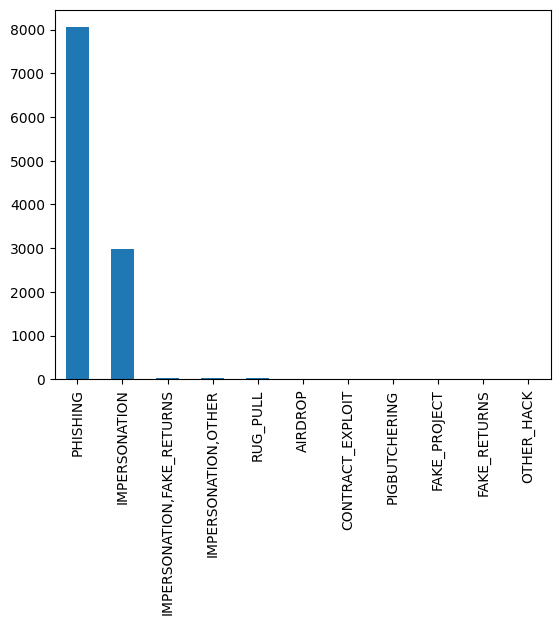

In [ ]:
combined_data['Scam_Types'].value_counts().plot(kind='bar')

<ipython-input-275-a6b4b19cccc5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Type']=Y['Scam_Types']


Type
AIRDROP                       [[Axes(0.125,0.11;0.336957x0.77), Axes(0.56304...
CONTRACT_EXPLOIT              [[Axes(0.125,0.11;0.336957x0.77), Axes(0.56304...
FAKE_PROJECT                  [[Axes(0.125,0.11;0.336957x0.77), Axes(0.56304...
FAKE_RETURNS                  [[Axes(0.125,0.11;0.336957x0.77), Axes(0.56304...
IMPERSONATION                 [[Axes(0.125,0.11;0.336957x0.77), Axes(0.56304...
IMPERSONATION,FAKE_RETURNS    [[Axes(0.125,0.11;0.336957x0.77), Axes(0.56304...
IMPERSONATION,OTHER           [[Axes(0.125,0.11;0.336957x0.77), Axes(0.56304...
OTHER_HACK                    [[Axes(0.125,0.11;0.336957x0.77), Axes(0.56304...
PHISHING                      [[Axes(0.125,0.11;0.336957x0.77), Axes(0.56304...
PIGBUTCHERING                 [[Axes(0.125,0.11;0.336957x0.77), Axes(0.56304...
RUG_PULL                      [[Axes(0.125,0.11;0.336957x0.77), Axes(0.56304...
dtype: object

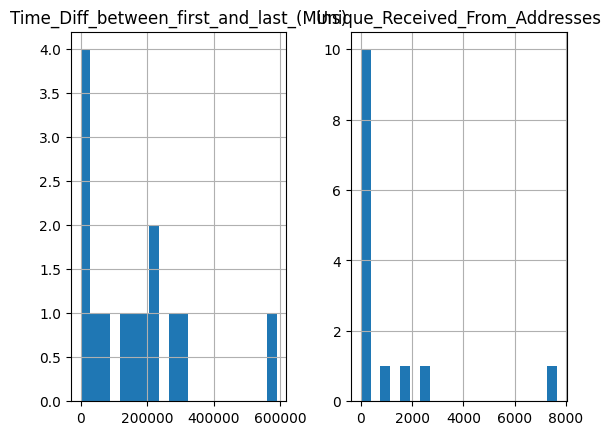

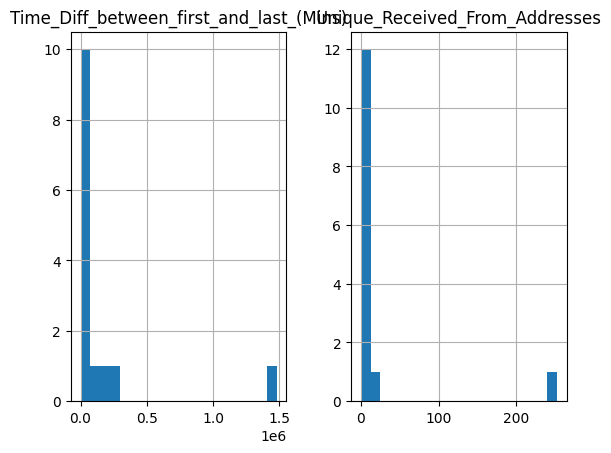

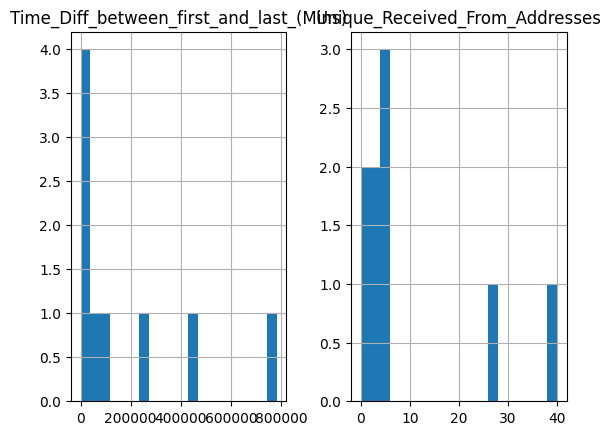

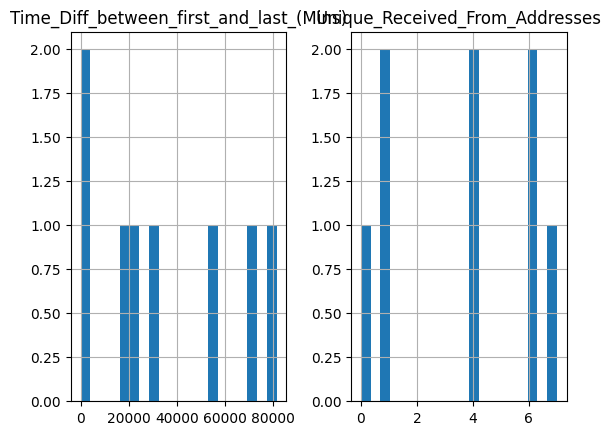

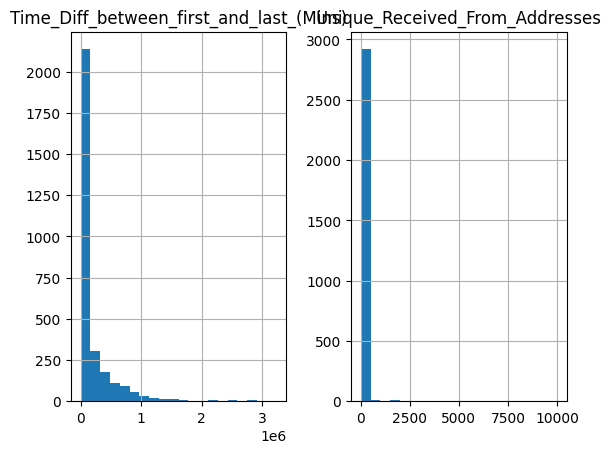

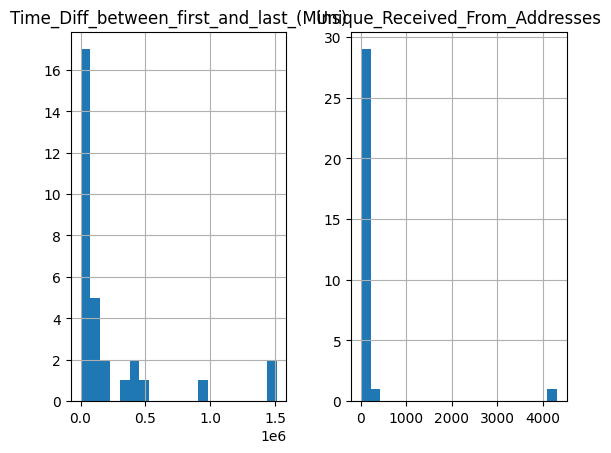

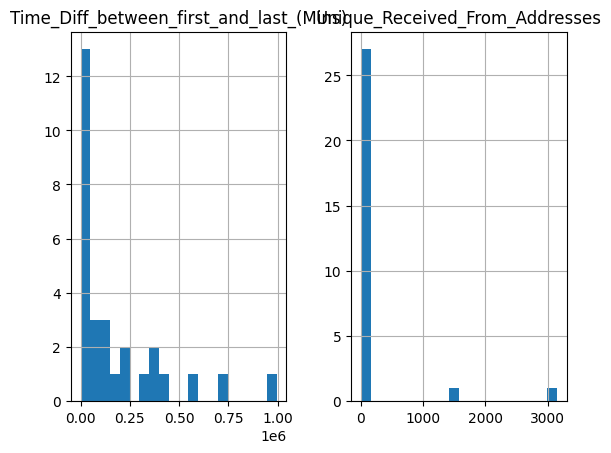

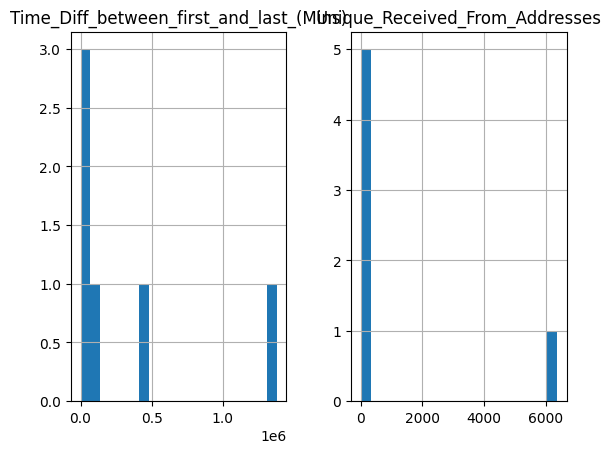

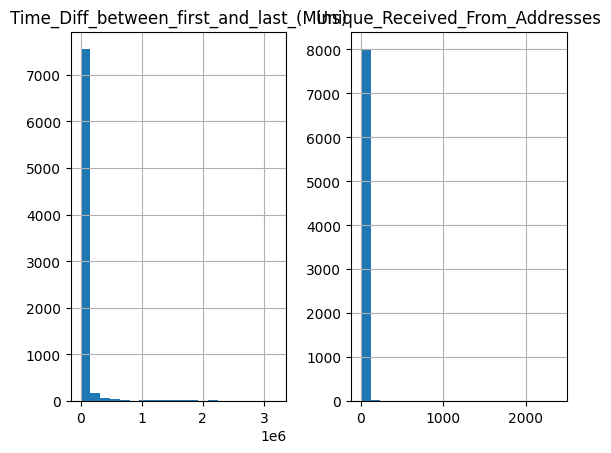

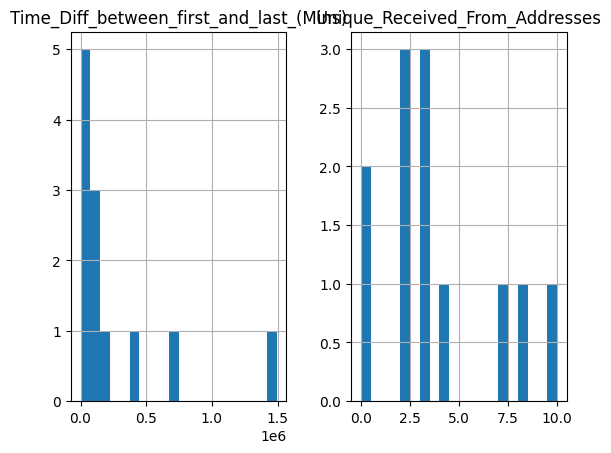

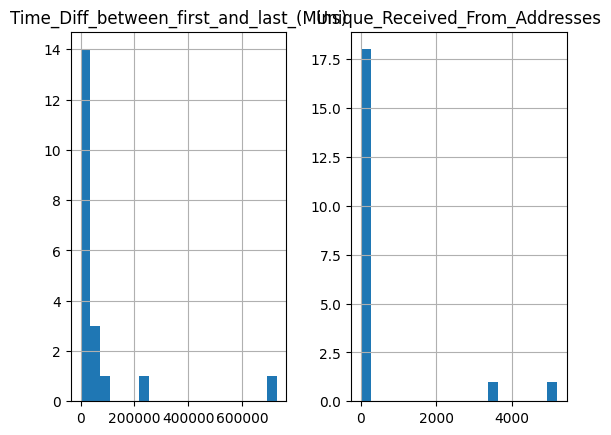

In [ ]:
X['Type']=Y['Scam_Types']
X.groupby('Type').hist(bins=20)

<Axes: ylabel='Frequency'>

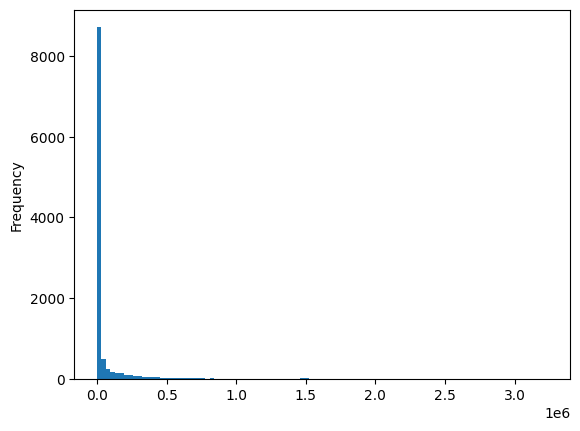

In [ ]:
X['Time_Diff_between_first_and_last_(Mins)'].plot.hist(bins=100)

<Axes: ylabel='Frequency'>

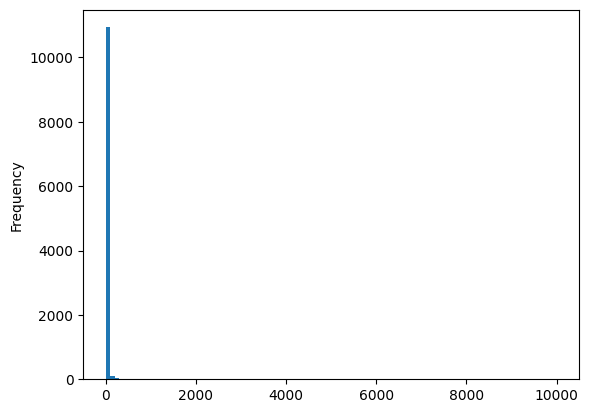

In [ ]:
X['Unique_Received_From_Addresses'].plot.hist(bins=100)